<a href="https://colab.research.google.com/github/PreethaJoy/GestureRecognition/blob/master/Gesture_Recognition_Code.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Gesture Recognition
In this group project, you are going to build a 3D Conv model that will be able to predict the 5 gestures correctly. Please import the following libraries to get started.

In [67]:
!pip install tensorflow-gpu==1.14.0
!pip install scipy==1.2.1
!pip install keras_applications==1.0.7

  Using cached https://files.pythonhosted.org/packages/76/04/43153bfdfcf6c9a4c38ecdb971ca9a75b9a791bb69a764d652c359aca504/tensorflow_gpu-1.14.0-cp36-cp36m-manylinux1_x86_64.whl
thinc 6.10.3 has requirement wrapt<1.11.0,>=1.10.0, but you'll have wrapt 1.12.1 which is incompatible.
spacy 2.0.12 has requirement regex==2017.4.5, but you'll have regex 2017.11.9 which is incompatible.
  Found existing installation: wrapt 1.10.11
Cannot uninstall 'wrapt'. It is a distutils installed project and thus we cannot accurately determine which files belong to it which would lead to only a partial uninstall.
You are using pip version 19.0.1, however version 20.0.2 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.
You are using pip version 19.0.1, however version 20.0.2 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.
You are using pip version 19.0.1, however version 20.0.2 is available.
You should consider upgrading via the

In [68]:
import numpy as np
import os
#from matplotlib.pyplot import imread
from scipy.misc import imread, imresize
import datetime
import os

We set the random seed so that the results don't vary drastically.

In [69]:
np.random.seed(30)
import random as rn
rn.seed(30)
#from keras import backend as K
import tensorflow as tf
tf.set_random_seed(30)

In [70]:
#from google.colab import drive
#drive.mount('/content/drive')

In this block, you read the folder names for training and validation. You also set the `batch_size` here. Note that you set the batch size in such a way that you are able to use the GPU in full capacity. You keep increasing the batch size until the machine throws an error.

In [71]:
#@title Default title text
train_doc = np.random.permutation(open('Project_data/train.csv').readlines())
val_doc = np.random.permutation(open('Project_data/val.csv').readlines())

batch_size = 8

/mnt/disks/user/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  """Entry point for launching an IPython kernel.
/mnt/disks/user/anaconda3/lib/python3.6/site-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/mnt/disks/user/anaconda3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


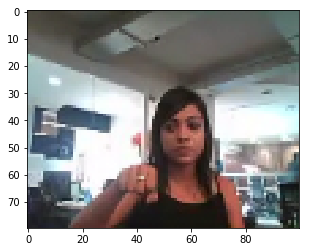

In [72]:
image = imread('Project_data/train/WIN_20180925_17_29_33_Pro_Stop_new/WIN_20180925_17_29_33_Pro_00002.png')
img_resized = resize(image, (80, 100))
plt.imshow(img_resized)

## Generator
This is one of the most important part of the code. The overall structure of the generator has been given. In the generator, you are going to preprocess the images as you have images of 2 different dimensions as well as create a batch of video frames. You have to experiment with `img_idx`, `y`,`z` and normalization such that you get high accuracy.

In [73]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import imread
from skimage.transform import resize
%matplotlib inline

def generator(source_path, folder_list, batch_size):
    print( 'Source path = ', source_path, '; batch size =', batch_size)
    img_idx = {1,3,5,7,9,11,13,15,17,19,21,23,25,27,29} #create a list of image numbers you want to use for a particular video
    while True:
        t = np.random.permutation(folder_list)
        num_batches = len(folder_list)//batch_size  # calculate the number of batches
        for batch in range(num_batches): # we iterate over the number of batches
            batch_data = np.zeros((batch_size,len(img_idx),80,100,3)) # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
            batch_labels = np.zeros((batch_size,5)) # batch_labels is the one hot representation of the output
            for folder in range(batch_size): # iterate over the batch_size
                imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) # read all the images in the folder
                for idx,item in enumerate(img_idx): #  Iterate over the frames/images of a folder to read them in
                    image = imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                    
                    #crop the images and resize them. Note that the images are of 2 different shape 
                    #and the conv3D will throw error if the inputs in a batch have different shapes
                    
                    #if image.shape[0] > 160 and image.shape[1] > 160:
                    #  img_resized = resize(image, (80, 100))
                    #else:
                    #  img_resized = image 
                    
                    img_resized = resize(image, (80, 100))
                 
                    batch_data[folder,idx,:,:,0] = img_resized[:,:,0]/255 #normalise and feed in the image
                    batch_data[folder,idx,:,:,1] = img_resized[:,:,1]/255 #normalise and feed in the image
                    batch_data[folder,idx,:,:,2] = img_resized[:,:,2]/255 #normalise and feed in the image

                batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
            yield batch_data, batch_labels #you yield the batch_data and the batch_labels, remember what does yield do

        
        # write the code for the remaining data points which are left after full batches
        rem_train_size = len(folder_list)%batch_size 
        batch_data = np.zeros((rem_train_size,len(img_idx),80,100,3)) # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
        batch_labels = np.zeros((rem_train_size,5)) # batch_labels is the one hot representation of the output
        for folder in range(rem_train_size): # iterate over the remaining training folders
            imgs = os.listdir(source_path+'/'+ t[folder + (num_batches*batch_size)].split(';')[0]) # read all the images in the folder
            for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
                image = imread(source_path+'/'+ t[folder + (num_batches*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                    
                #crop the images and resize them. Note that the images are of 2 different shape 
                #and the conv3D will throw error if the inputs in a batch have different shapes
                
                #if image.shape[0] > 160 and image.shape[1] > 160:
                #  img_resized = resize(image, (80, 100))
                #else:
                #  img_resized = image
                
                img_resized = resize(image, (80, 100))
                    
                batch_data[folder,idx,:,:,0] = img_resized[:,:,0]/255 #normalise and feed in the image
                batch_data[folder,idx,:,:,1] = img_resized[:,:,1]/255 #normalise and feed in the image
                batch_data[folder,idx,:,:,2] = img_resized[:,:,2]/255 #normalise and feed in the image
                    
            batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
        yield batch_data, batch_labels #you yield the batch_data and the batch_labels, remember what does yield do


Note here that a video is represented above in the generator as (number of images, height, width, number of channels). Take this into consideration while creating the model architecture.

In [74]:
curr_dt_time = datetime.datetime.now()
train_path = 'Project_data/train'
val_path = 'Project_data/val'
num_train_sequences = len(train_doc)
print('# training sequences =', num_train_sequences)
num_val_sequences = len(val_doc)
print('# validation sequences =', num_val_sequences)
num_epochs = 50 # choose the number of epochs
print ('# epochs =', num_epochs)

# training sequences = 663
# validation sequences = 100
# epochs = 50


## Model
Here you make the model using different functionalities that Keras provides. Remember to use `Conv3D` and `MaxPooling3D` and not `Conv2D` and `Maxpooling2D` for a 3D convolution model. You would want to use `TimeDistributed` while building a Conv2D + RNN model. Also remember that the last layer is the softmax. Design the network in such a way that the model is able to give good accuracy on the least number of parameters so that it can fit in the memory of the webcam.

In [75]:
from keras.models import Sequential, Model
from keras.layers import Dense, GRU, Flatten, TimeDistributed, Flatten, BatchNormalization, Activation
from keras.layers.convolutional import Conv3D, MaxPooling3D
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras import optimizers
from keras.optimizers import Adam

input_shape = (15, 80, 100, 3)
num_classes = 5

#write your model here
model = Sequential()
model.add(Conv3D(32, kernel_size=(3, 3, 3), activation='relu', kernel_initializer='he_uniform',  input_shape=input_shape))
model.add(MaxPooling3D(pool_size=(2, 2, 2)))
model.add(Conv3D(64, kernel_size=(3, 3, 3), activation='relu', kernel_initializer='he_uniform'))
model.add(MaxPooling3D(pool_size=(2, 2, 2)))
#model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128, activation='relu')) # fully connected
#model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax', kernel_initializer='he_uniform'))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_9 (Conv3D)            (None, 13, 78, 98, 32)    2624      
_________________________________________________________________
max_pooling3d_9 (MaxPooling3 (None, 6, 39, 49, 32)     0         
_________________________________________________________________
conv3d_10 (Conv3D)           (None, 4, 37, 47, 64)     55360     
_________________________________________________________________
max_pooling3d_10 (MaxPooling (None, 2, 18, 23, 64)     0         
_________________________________________________________________
flatten_5 (Flatten)          (None, 52992)             0         
_________________________________________________________________
dense_9 (Dense)              (None, 128)               6783104   
_________________________________________________________________
dense_10 (Dense)             (None, 5)                 645       
Total para

Now that you have written the model, the next step is to `compile` the model. When you print the `summary` of the model, you'll see the total number of parameters you have to train.

In [76]:
optimiser = Adam(lr=0.0001)
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_9 (Conv3D)            (None, 13, 78, 98, 32)    2624      
_________________________________________________________________
max_pooling3d_9 (MaxPooling3 (None, 6, 39, 49, 32)     0         
_________________________________________________________________
conv3d_10 (Conv3D)           (None, 4, 37, 47, 64)     55360     
_________________________________________________________________
max_pooling3d_10 (MaxPooling (None, 2, 18, 23, 64)     0         
_________________________________________________________________
flatten_5 (Flatten)          (None, 52992)             0         
_________________________________________________________________
dense_9 (Dense)              (None, 128)               6783104   
_________________________________________________________________
dense_10 (Dense)             (None, 5)                 645       
Total para

Let us create the `train_generator` and the `val_generator` which will be used in `.fit_generator`.

In [77]:
train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)

In [78]:
model_name = 'model_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)

LR = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.001)
callbacks_list = [checkpoint, LR]

The `steps_per_epoch` and `validation_steps` are used by `fit_generator` to decide the number of next() calls it need to make.

In [79]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

Let us now fit the model. This will start training the model and with the help of the checkpoints, you'll be able to save the model at the end of each epoch.

In [80]:
modelhistory = model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                                   callbacks=callbacks_list, validation_data=val_generator, 
                                   validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path =  Project_data/val ; batch size = 8
Source path =  Project_data/train ; batch size = 8
Epoch 1/50


/mnt/disks/user/anaconda3/lib/python3.6/site-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/mnt/disks/user/anaconda3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


83/83 [==============================] - 91s 1s/step - loss: 1.5995 - categorical_accuracy: 0.2020 - val_loss: 1.5688 - val_categorical_accuracy: 0.2300

Epoch 00001: saving model to model_init_2020-03-1917_07_28.065557/model-00001-1.59951-0.20211-1.56881-0.23000.h5
Epoch 2/50
83/83 [==============================] - 51s 612ms/step - loss: 1.5431 - categorical_accuracy: 0.2425 - val_loss: 1.4835 - val_categorical_accuracy: 0.3900

Epoch 00002: saving model to model_init_2020-03-1917_07_28.065557/model-00002-1.54280-0.24284-1.48354-0.39000.h5
Epoch 3/50
83/83 [==============================] - 55s 659ms/step - loss: 1.4031 - categorical_accuracy: 0.4570 - val_loss: 1.3573 - val_categorical_accuracy: 0.4100

Epoch 00003: saving model to model_init_2020-03-1917_07_28.065557/model-00003-1.40277-0.45701-1.35734-0.41000.h5
Epoch 4/50
83/83 [==============================] - 57s 687ms/step - loss: 1.2527 - categorical_accuracy: 0.5121 - val_loss: 1.2932 - val_categorical_accuracy: 0.5200

Epo

83/83 [==============================] - 61s 730ms/step - loss: 0.5664 - categorical_accuracy: 0.7954 - val_loss: 0.9178 - val_categorical_accuracy: 0.6200

Epoch 00030: saving model to model_init_2020-03-1917_07_28.065557/model-00030-0.56008-0.79638-0.91782-0.62000.h5
Epoch 31/50
83/83 [==============================] - 56s 669ms/step - loss: 0.5024 - categorical_accuracy: 0.8320 - val_loss: 1.0028 - val_categorical_accuracy: 0.6100

Epoch 00031: saving model to model_init_2020-03-1917_07_28.065557/model-00031-0.50019-0.83258-1.00284-0.61000.h5
Epoch 32/50
83/83 [==============================] - 56s 678ms/step - loss: 0.4919 - categorical_accuracy: 0.8408 - val_loss: 0.9945 - val_categorical_accuracy: 0.6300

Epoch 00032: saving model to model_init_2020-03-1917_07_28.065557/model-00032-0.48903-0.84163-0.99454-0.63000.h5
Epoch 33/50
83/83 [==============================] - 55s 660ms/step - loss: 0.5283 - categorical_accuracy: 0.8374 - val_loss: 1.0188 - val_categorical_accuracy: 0.620

In [81]:
acc = modelhistory.history['categorical_accuracy']
val_acc = modelhistory.history['val_categorical_accuracy']
loss = modelhistory.history['loss']
val_loss = modelhistory.history['val_loss']

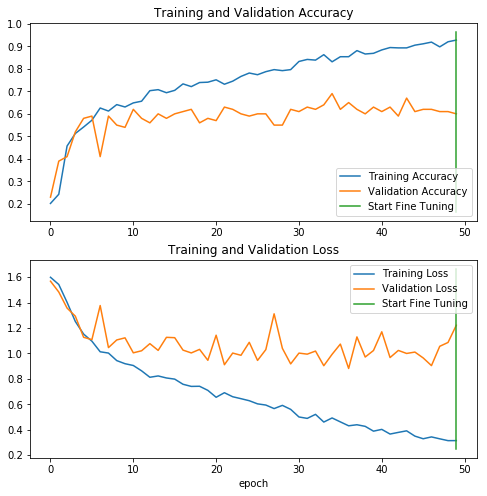

In [82]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.plot([num_epochs-1,num_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.plot([num_epochs-1,num_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()